# <font color = 'pickle'> Install Libraries/ Set Google Colab

In [ ]:
from pathlib import Path
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install --upgrade fastai timm kaggle -qq
  base_folder = Path('/content/drive/MyDrive/data')
  data_folder = Path('/content')
else:
  base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor/data')
  data_folder = Path('/home/harpreet/data')
  print('Not running on CoLab')

Running on CoLab
Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.4 MB/s eta 0:00:00


# <font color = 'pickle'> Specify Project Folder

In [ ]:
kaggle_api = base_folder/'.kaggle'
data_folder = data_folder/'inclass_kaggle_data'
model_folder = base_folder/'models/dl_fall_2023/inclass_kaglle'
archive_folder  = data_folder/'archive'

In [ ]:
data_folder.mkdir(exist_ok=True)
kaggle_api.mkdir(exist_ok=True)
model_folder.mkdir(exist_ok=True, parents=True)
archive_folder.mkdir(exist_ok=True)


In [ ]:
import os
if 'google.colab' in str(get_ipython()):
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/data/.kaggle/"

In [ ]:
if 'google.colab' in str(get_ipython()):
    !chmod 600 /content/drive/MyDrive/data/.kaggle/kaggle.json

In [ ]:
if 'google.colab' in str(get_ipython()):
    ! ls -la  /content/drive/MyDrive/data/.kaggle/kaggle.json

-rw------- 1 root root 67 Nov 29 21:08 /content/drive/MyDrive/data/.kaggle/kaggle.json


# <font color = 'pickle'> Import Libraries

In [ ]:
import fastai; fastai.__version__

'2.7.13'

In [ ]:
from fastai.vision.all import *
from kaggle import api
from zipfile import ZipFile
import timm

# <font color = 'pickle'> Get Data from kaggle

In [ ]:
! kaggle competitions download inclassplantpathologysmallf23 -p {archive_folder}


100% 551M/552M [00:18<00:00, 37.5MB/s]
100% 552M/552M [00:18<00:00, 31.6MB/s]


In [ ]:
file = archive_folder/'inclassplantpathologysmallf23.zip'
with ZipFile(file , 'r') as f:
    filenames = f.namelist()

In [ ]:
filenames[0:10]

['sample_submission.csv',
 'test/test/test_image_1.jpg',
 'test/test/test_image_10.jpg',
 'test/test/test_image_100.jpg',
 'test/test/test_image_1000.jpg',
 'test/test/test_image_1001.jpg',
 'test/test/test_image_1002.jpg',
 'test/test/test_image_1003.jpg',
 'test/test/test_image_1004.jpg',
 'test/test/test_image_1005.jpg']

In [ ]:
with ZipFile(file ,'r') as f:
 f.extractall(path = data_folder)

# <font color = 'pickle'> Understand Data

In [ ]:
train_path = data_folder/'train/train'

In [ ]:
files = get_image_files(train_path)

##  <font color = 'pickle'>Look at a sample Image

(600, 400)


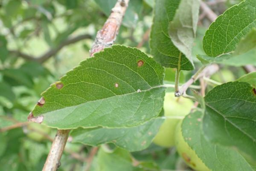

In [ ]:
sample_image = PILImage.create(files[0])
print(sample_image.size)
sample_image.to_thumb(256)

##  <font color = 'pickle'> Check size of all the images

In [ ]:
from fastcore.parallel import *

In [ ]:
def get_sizes(image):
    return PILImage.create(image).size

In [ ]:
sizes = parallel(get_sizes, files, progress=True)

In [ ]:
pd.Series(sizes).value_counts()

(600, 400)    12409
(600, 450)      627
(600, 600)        3
(450, 600)        2
(600, 337)        1
dtype: int64

# <font color = 'pickle'> Data Loader

In [ ]:
df = pd.read_csv(data_folder/'train.csv')

In [ ]:
df.head()

,image,labels
0,train_image_1.jpg,powdery_mildew
1,train_image_2.jpg,scab
2,train_image_3.jpg,scab frog_eye_leaf_spot
3,train_image_4.jpg,powdery_mildew
4,train_image_5.jpg,complex


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13042 entries, 0 to 13041
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   13042 non-null  object
 1   labels  13042 non-null  object
dtypes: object(2)
memory usage: 203.9+ KB


In [ ]:
df.iloc[0:10, ]

,image,labels
0,train_image_1.jpg,powdery_mildew
1,train_image_2.jpg,scab
2,train_image_3.jpg,scab frog_eye_leaf_spot
3,train_image_4.jpg,powdery_mildew
4,train_image_5.jpg,complex
5,train_image_6.jpg,rust
6,train_image_7.jpg,scab frog_eye_leaf_spot
7,train_image_8.jpg,scab frog_eye_leaf_spot
8,train_image_9.jpg,frog_eye_leaf_spot
9,train_image_10.jpg,frog_eye_leaf_spot


In [ ]:
# def get_x(df): return str(small_train_images) + '/' + (df['image'])
def get_x(df):
  return data_folder/'train/train'/df['image']
def get_y(df):
  return df['labels'].split(' ')
dblock = DataBlock(get_x= get_x,
                   get_y = get_y,
                   splitter = RandomSplitter(seed = 42))
dsets = dblock.datasets(df)
dsets.train[15]

(Path('/content/inclass_kaggle_data/train/train/train_image_10535.jpg'),
 ['rust', 'complex'])

In [ ]:

dblock = DataBlock(blocks= (ImageBlock, MultiCategoryBlock),
                   get_x= get_x,
                   get_y = get_y,
                  splitter = RandomSplitter(seed = 42))
dsets = dblock.datasets(df)
dsets.train[15]

(PILImage mode=RGB size=600x400, TensorMultiCategory([1., 0., 0., 0., 1., 0.]))

In [ ]:
dsets.train.vocab

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [ ]:
idxs = torch.where(dsets.train[15][1] == 1.)[0]

In [ ]:
dsets.train.vocab[idxs]

(#2) ['complex','rust']

In [ ]:
dblock = DataBlock(blocks= (ImageBlock, MultiCategoryBlock),
                  get_x= get_x,
                  get_y = get_y,
                  splitter = RandomSplitter(seed = 42),
                  item_tfms= Resize(400, method = 'squish'),
                  batch_tfms= aug_transforms(size = 128, min_scale = 0.75))
dsets = dblock.datasets(df)
dsets.train[3]

(PILImage mode=RGB size=600x400, TensorMultiCategory([0., 0., 0., 0., 0., 1.]))

In [ ]:
import os
os.cpu_count()

8

In [ ]:
dls = dblock.dataloaders(df, bs = 64, num_workers =8)

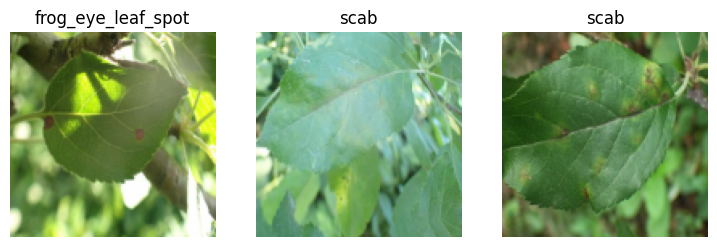

In [ ]:
dls.train.show_batch(max_n=3)

In [ ]:
dls.device

device(type='cuda', index=0)

# <font color = 'pickle'> Model

In [ ]:
f1score = F1ScoreMulti(thresh = 0.5)
loss_func = nn.BCEWithLogitsLoss()
# learn = vision_learner(dls,'resnext101_32x8d', metrics = [F1ScoreMulti(thresh = 0.5)], path = model_folder).to_fp16()

In [ ]:
from fastai.vision.all import *

# Assuming you have defined your DataLoaders (dls), loss function (loss_func), and F1ScoreMulti metric (f1score)

# Load the EfficientNet-B0 model
efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)

# Replace the last layer to fit your number of classes
num_classes = 6  # Adjust this to the number of classes in your dataset
efficientnet_model.classifier = nn.Linear(efficientnet_model.classifier.in_features, num_classes)

# Create a Learner object
learn = Learner(dls, efficientnet_model, loss_func=loss_func, metrics=[f1score], path=model_folder).to_fp16()


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.002754228748381138, steep=0.004365158267319202, valley=0.0003981071640737355, slide=0.0012022644514217973)

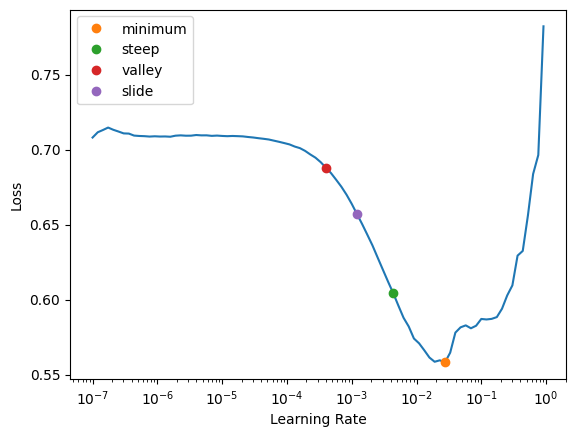

In [ ]:
learn.lr_find(suggest_funcs = (minimum, steep, valley, slide))

In [ ]:
learn.fine_tune(15, 0.03)

epoch,train_loss,valid_loss,f1_score,time
0,0.282906,2.001071,0.304110,00:31


epoch,train_loss,valid_loss,f1_score,time
0,0.163167,0.185650,0.779443,00:31
1,0.160975,0.267256,0.670624,00:31
2,0.167469,0.210501,0.749753,00:30
3,0.172069,0.420486,0.551807,00:31
4,0.158168,0.241718,0.709374,00:31
5,0.148901,0.210317,0.686071,00:31
6,0.143200,0.213485,0.735045,00:31
7,0.135577,0.160675,0.798741,00:30
8,0.126155,0.132559,0.832934,00:31
9,0.116209,0.115023,0.859482,00:31


# <font color ='pickle'> Find the threshold

In [ ]:
F1ScoreMulti??

In [ ]:
learn.metrics = F1ScoreMulti(thresh = 0.1)

In [ ]:
learn.metrics

(#1) [<fastai.metrics.AccumMetric object at 0x7ec4117da980>]

In [ ]:
learn.validate()

(#2) [0.09707555174827576,0.844251746763477]

In [ ]:
learn.metrics = F1ScoreMulti(thresh = 0.9)

In [ ]:
learn.validate()

(#2) [0.09707555174827576,0.7814674104708508]

In [ ]:
preds, targs = learn.get_preds()

In [ ]:
preds.shape, targs.shape

(torch.Size([2608, 6]), torch.Size([2608, 6]))

In [ ]:
f1score = F1ScoreMulti(thresh = None, sigmoid=False)

In [ ]:
idxs = (preds>0.5) * 1

In [ ]:
f1score(idxs, targs)

0.8737271944107539

In [ ]:
xs = torch.linspace(0.05, 0.95, 29)

In [ ]:
f1scores = [f1score((preds>i) * 1, targs) for i in xs]

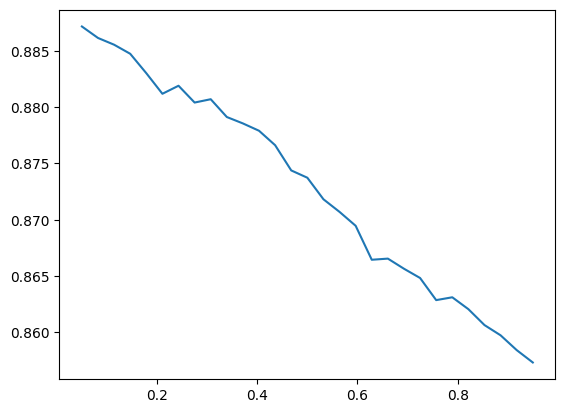

In [ ]:
plt.plot(xs, f1scores)

In [ ]:
torch.argmax(torch.tensor(f1scores))

tensor(0)

In [ ]:
xs[9]

tensor(0.3393)

In [ ]:
f1scores[9]

0.8791184830752793

# <font color ='pickle'>Test Predictions

In [ ]:
test_files = get_image_files(data_folder/'test/test').sorted()

In [ ]:
test_files

(#5590) [Path('/content/inclass_kaggle_data/test/test/test_image_1.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_10.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_100.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1000.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1001.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1002.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1003.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1004.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1005.jpg'),Path('/content/inclass_kaggle_data/test/test/test_image_1006.jpg')...]

In [ ]:
test_dl = learn.dls.test_dl(test_files)

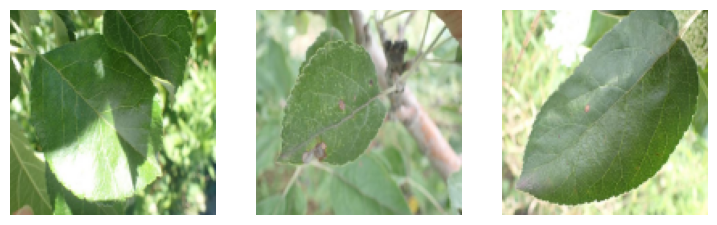

In [ ]:
test_dl.show_batch(max_n=3)

In [ ]:
preds, _ = learn.tta(dl = test_dl)

In [ ]:
preds

tensor([[ -7.3591,  -8.0981,   3.8993,  -6.2805, -10.5625,  -4.2968],
        [  0.7939,   0.2590,  -8.1819,  -5.9590,  -4.9531,  -2.0347],
        [ -2.3007,   2.6519,  -8.3975,  -5.5188,  -5.0308,  -4.1536],
        ...,
        [ -8.0022,  -8.9988,   5.7029,  -7.2893, -11.5054,  -7.1448],
        [ -0.3864,   1.5911,  -7.5972,  -6.8396,  -5.2427,  -1.9347],
        [ -5.0730,  -7.6814,  -8.5630,   6.5549, -10.1694,  -7.3232]])

In [ ]:
pred_decoded = [torch.where(pred>0.5)[0] for pred in preds]

In [ ]:
pred_decoded[0:20]

[tensor([2]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([], dtype=torch.int64),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([0]),
 tensor([5]),
 tensor([2]),
 tensor([5]),
 tensor([2]),
 tensor([1]),
 tensor([5]),
 tensor([5]),
 tensor([4]),
 tensor([2]),
 tensor([2]),
 tensor([5])]

In [ ]:
vocab = learn.dls.vocab

In [ ]:
pred_labels = [vocab[pred] for pred in pred_decoded[0:20]]

In [ ]:
pred_labels

[(#1) ['healthy'],
 (#1) ['complex'],
 (#1) ['frog_eye_leaf_spot'],
 (#1) ['frog_eye_leaf_spot'],
 (#0) [],
 (#1) ['frog_eye_leaf_spot'],
 (#1) ['frog_eye_leaf_spot'],
 (#1) ['complex'],
 (#1) ['complex'],
 (#1) ['scab'],
 (#1) ['healthy'],
 (#1) ['scab'],
 (#1) ['healthy'],
 (#1) ['frog_eye_leaf_spot'],
 (#1) ['scab'],
 (#1) ['scab'],
 (#1) ['rust'],
 (#1) ['healthy'],
 (#1) ['healthy'],
 (#1) ['scab']]

In [ ]:
[" ".join(pred)for pred in pred_labels]

['healthy',
 'complex',
 'frog_eye_leaf_spot',
 'frog_eye_leaf_spot',
 '',
 'frog_eye_leaf_spot',
 'frog_eye_leaf_spot',
 'complex',
 'complex',
 'scab',
 'healthy',
 'scab',
 'healthy',
 'frog_eye_leaf_spot',
 'scab',
 'scab',
 'rust',
 'healthy',
 'healthy',
 'scab']

In [ ]:
pred_labels = [' '.join(vocab[torch.where(pred>0.5)[0]]) for pred in preds]

In [ ]:
pred_labels[0:20]

['healthy',
 'complex',
 'frog_eye_leaf_spot',
 'frog_eye_leaf_spot',
 '',
 'frog_eye_leaf_spot',
 'frog_eye_leaf_spot',
 'complex',
 'complex',
 'scab',
 'healthy',
 'scab',
 'healthy',
 'frog_eye_leaf_spot',
 'scab',
 'scab',
 'rust',
 'healthy',
 'healthy',
 'scab']

# <font color ='pickle'> Kaggle Submission

In [ ]:
sample_submission= pd.read_csv(data_folder/'sample_submission.csv')

In [ ]:
sample_submission

,image,labels
0,test_image_1.jpg,healthy
1,test_image_2.jpg,healthy
2,test_image_3.jpg,healthy
3,test_image_4.jpg,healthy
4,test_image_5.jpg,healthy
...,...,...
5585,test_image_5586.jpg,healthy
5586,test_image_5587.jpg,healthy
5587,test_image_5588.jpg,healthy
5588,test_image_5589.jpg,healthy


In [ ]:
sample_submission = sample_submission.sort_values(by = 'image')


In [ ]:
sample_submission

,image,labels
0,test_image_1.jpg,healthy
9,test_image_10.jpg,healthy
99,test_image_100.jpg,healthy
999,test_image_1000.jpg,healthy
1000,test_image_1001.jpg,healthy
...,...,...
994,test_image_995.jpg,healthy
995,test_image_996.jpg,healthy
996,test_image_997.jpg,healthy
997,test_image_998.jpg,healthy


In [ ]:
sample_submission['labels'] = pred_labels

In [ ]:
sample_submission

,image,labels
0,test_image_1.jpg,healthy
9,test_image_10.jpg,complex
99,test_image_100.jpg,frog_eye_leaf_spot
999,test_image_1000.jpg,frog_eye_leaf_spot
1000,test_image_1001.jpg,
...,...,...
994,test_image_995.jpg,powdery_mildew
995,test_image_996.jpg,healthy
996,test_image_997.jpg,healthy
997,test_image_998.jpg,frog_eye_leaf_spot


In [ ]:
sample_submission.to_csv(model_folder/'Navya_final_sub.csv', index = False)

In [ ]:
!head {model_folder/'Navya_final_sub.csv'}

image,labels
test_image_1.jpg,healthy
test_image_10.jpg,complex
test_image_100.jpg,frog_eye_leaf_spot
test_image_1000.jpg,frog_eye_leaf_spot
test_image_1001.jpg,
test_image_1002.jpg,frog_eye_leaf_spot
test_image_1003.jpg,frog_eye_leaf_spot
test_image_1004.jpg,complex
test_image_1005.jpg,complex


In [ ]:
comp = 'inclassplantpathologysmallf23'
api.competition_submit(model_folder/'Navya_final_sub.csv', 'inclass nov14', comp)

100%|██████████| 159k/159k [00:00<00:00, 192kB/s]


Successfully submitted to Inclass_Plant_Pathology_Small_F23